In [3]:
import os
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import sklearn 
import matplotlib

# Data visu 

In [4]:
#data importation 
data = pd.read_csv("datas/simulated_4K_cloud_gaming_dataset.csv")

print("dataframe information gathering ")

print (data.head())
print (data.index)
print (data.columns)
print (data.dtypes)
print (data.info())
print (data.describe())




dataframe information gathering 
   CPU_usage  GPU_usage  Bandwidth_MBps  Latency_ms  FrameRate_fps  Jitter_ms  \
0         71         65       19.770323   66.202388      59.107060  13.085300   
1         34         40        8.092595   32.207380      57.969683   8.567330   
2         91         55       16.841666  133.478904      52.248079   1.129479   
3         80         73       15.702267  125.328933      38.382477  10.944737   
4         40         76       11.227322  111.041017      33.949608  18.508754   

   QoE_score  
0          3  
1          3  
2          1  
3          1  
4          2  
RangeIndex(start=0, stop=1000, step=1)
Index(['CPU_usage', 'GPU_usage', 'Bandwidth_MBps', 'Latency_ms',
       'FrameRate_fps', 'Jitter_ms', 'QoE_score'],
      dtype='object')
CPU_usage           int64
GPU_usage           int64
Bandwidth_MBps    float64
Latency_ms        float64
FrameRate_fps     float64
Jitter_ms         float64
QoE_score           int64
dtype: object
<class 'pandas.co

# Data Cleaning 

In [5]:
print (data.shape)

(1000, 7)


In [6]:
data = data.dropna()
data = data.drop_duplicates()

In [7]:
print (data.shape)

(1000, 7)


# Visualisation

In [8]:
print(data['QoE_score'].value_counts())

QoE_score
3    379
2    312
1    222
4     84
5      3
Name: count, dtype: int64


## Déséquilibre des classes (ou des notes de QoE à gérer)

<Figure size 1000x600 with 0 Axes>

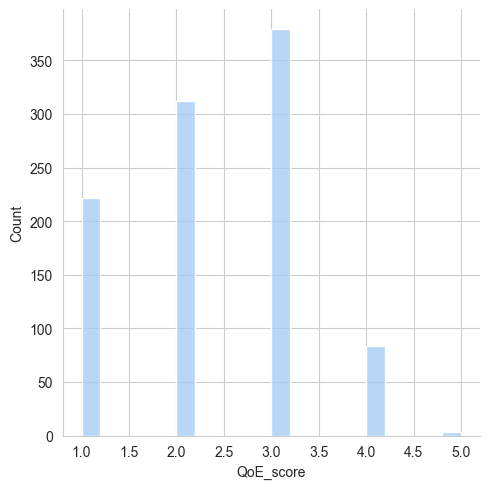

In [9]:
plt.figure(figsize=(10,6))
sns.set_style("whitegrid")
sns.set_palette("pastel")
sns.displot(data['QoE_score'])
plt.show()

### View of key features 

<Axes: xlabel='QoE_score', ylabel='Latency_ms'>

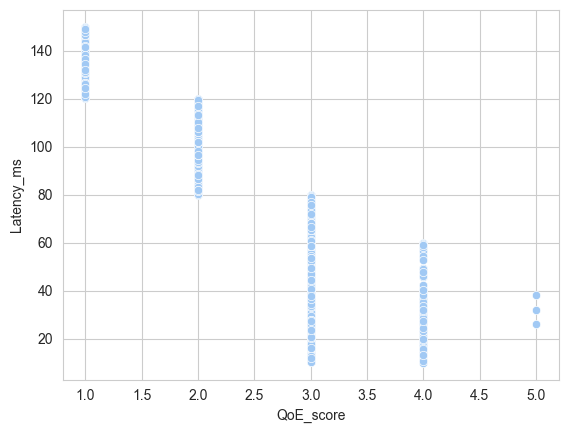

In [10]:
sns.scatterplot(data = data, x = 'QoE_score', y = 'Latency_ms')

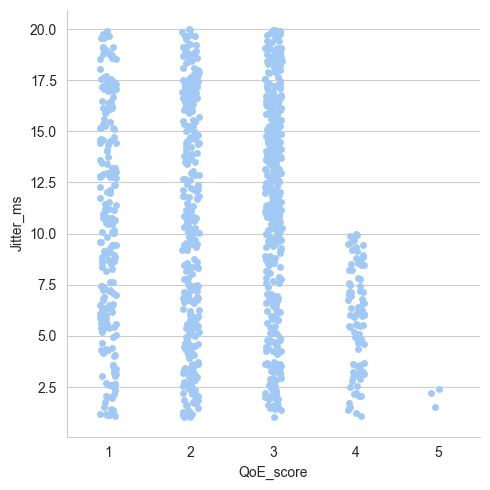

In [11]:
sns.catplot(data= data, x='QoE_score', y = 'Jitter_ms')

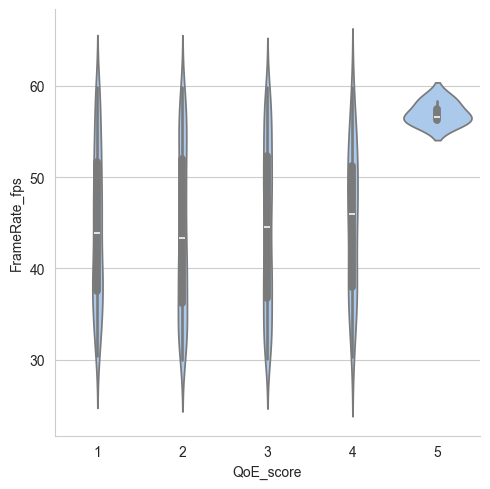

In [12]:
sns.catplot(data= data,kind='violin', x='QoE_score', y = 'FrameRate_fps')

<Axes: xlabel='QoE_score', ylabel='Bandwidth_MBps'>

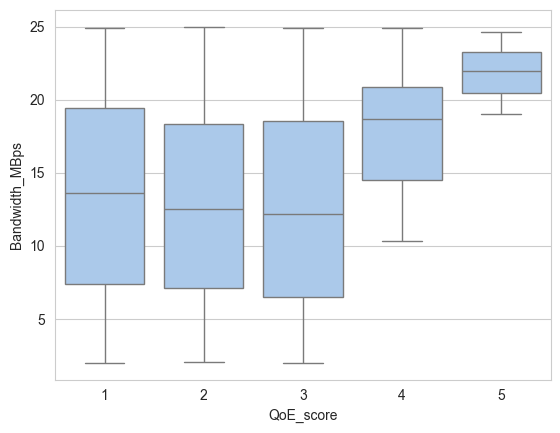

In [13]:
sns.boxplot(data=data, x='QoE_score', y= 'Bandwidth_MBps')

<Axes: xlabel='QoE_score', ylabel='CPU_usage'>

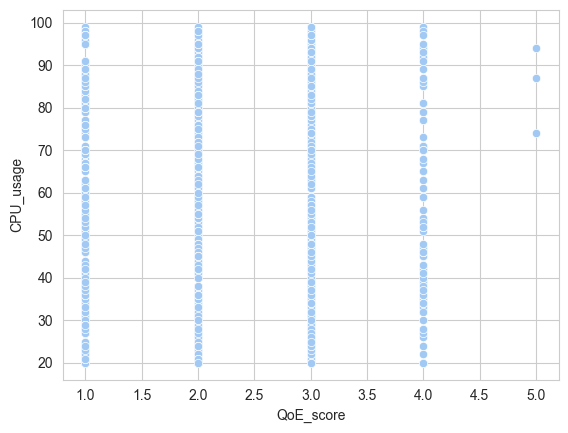

In [14]:
sns.scatterplot(data = data, x = 'QoE_score', y = 'CPU_usage')


<Axes: xlabel='QoE_score', ylabel='GPU_usage'>

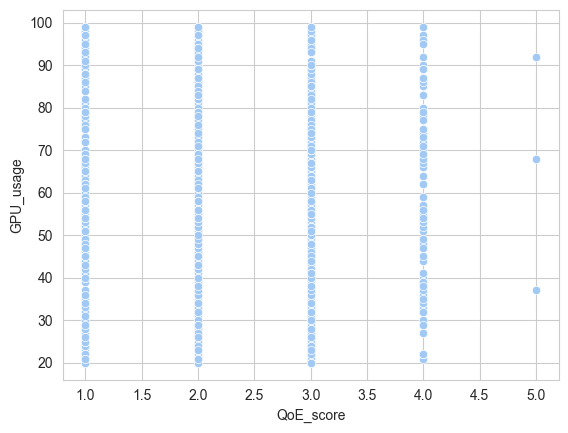

In [15]:
sns.scatterplot(data = data, x = 'QoE_score', y = 'GPU_usage')


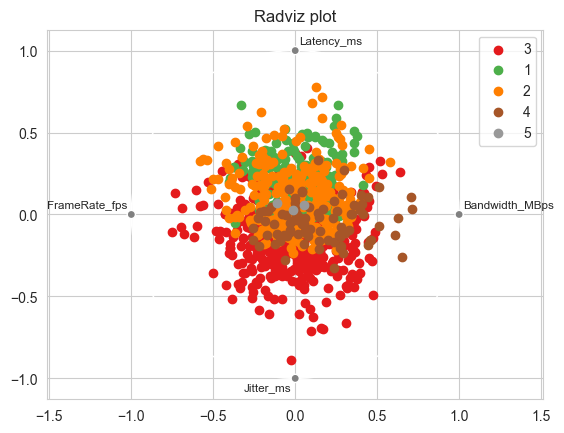

In [16]:
from pandas.plotting import radviz 

cols = ['Bandwidth_MBps', 'Latency_ms', 'FrameRate_fps', 'Jitter_ms', 'QoE_score']
radviz(data[cols], class_column='QoE_score', colormap='Set1')
plt.title('Radviz plot')
plt.show()


# Models training and comparaison of performance

In [17]:
X = data.drop('QoE_score', axis=1)
y = data['QoE_score']

In [18]:
from sklearn.model_selection import  train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

In [19]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso 
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

from xgboost import XGBRegressor


In [20]:
models = {
    'LinearRegression': LinearRegression(),
    'Ridge' : Ridge(),
    'Lasso': Lasso(),
    'RandomForestRegressor' : RandomForestRegressor(random_state=42),
    'GradientBoostingRegressor': GradientBoostingRegressor(random_state=42),
    'SVR': SVR(),
    'DecisionTreeRegressor' : DecisionTreeRegressor(random_state=42),
    'KNeighborsRegressor': KNeighborsRegressor(),
    'XGBRegressor': XGBRegressor(random_state = 42, verbosity = 0)
}

In [21]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

In [22]:
# Standardisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [23]:
# Résultats globaux et erreurs par QoE
results = []
errors_by_class = {}

for name, model in models.items():
    if name in ['LinearRegression', 'Ridge', 'Lasso', 'SVR', 'KNeighborsRegressor']:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results.append({'Model': name, 'MAE': mae, 'RMSE': rmse, 'R2': r2})
    
    df_temp = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred})
    class_errors = df_temp.groupby('y_true').apply(lambda g: mean_absolute_error(g['y_true'], g['y_pred']))
    errors_by_class[name] = class_errors

# Convertir en DataFrames
df_results = pd.DataFrame(results).set_index('Model').sort_values('MAE')
df_errors = pd.DataFrame(errors_by_class).T.sort_index()


In [24]:
# Résultats globaux
display(df_results)

# Erreurs par QoE score
print("Erreur absolue moyenne par QoE score :")
display(df_errors)


MAE      RMSE        R2
Model                                                  
XGBRegressor               0.016171  0.114443  0.984220
DecisionTreeRegressor      0.020000  0.141421  0.975903
RandomForestRegressor      0.029700  0.134270  0.978279
GradientBoostingRegressor  0.058205  0.144116  0.974976
SVR                        0.270932  0.342437  0.858717
KNeighborsRegressor        0.319333  0.421900  0.785539
LinearRegression           0.342560  0.417534  0.789956
Ridge                      0.342586  0.417485  0.790005
Lasso                      0.789971  0.911045 -0.000017

Erreur absolue moyenne par QoE score :


y_true                            1         2         3         4         5
DecisionTreeRegressor      0.000000  0.000000  0.034188  0.043478  1.000000
GradientBoostingRegressor  0.007632  0.011071  0.106684  0.117619  0.737662
KNeighborsRegressor        0.366154  0.308511  0.241026  0.600000  1.000000
Lasso                      1.332857  0.332857  0.667143  1.667143  2.667143
LinearRegression           0.303766  0.245517  0.376721  0.636565  1.227375
RandomForestRegressor      0.001231  0.000106  0.043590  0.126087  0.820000
Ridge                      0.304891  0.245120  0.376178  0.638023  1.229330
SVR                        0.205008  0.314806  0.213676  0.527357  1.232886
XGBRegressor               0.030826  0.000016  0.006268  0.088976  0.066359

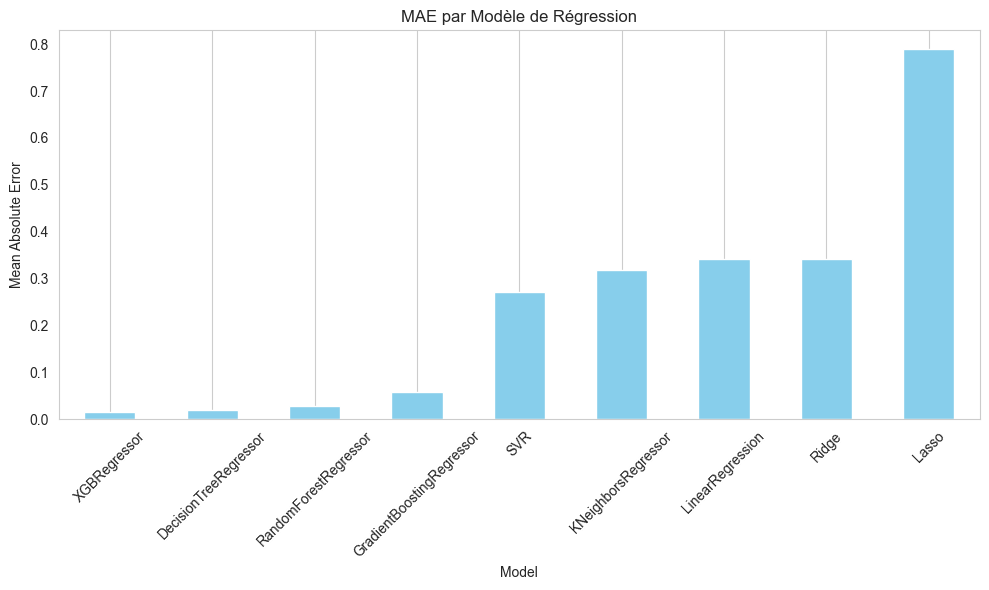

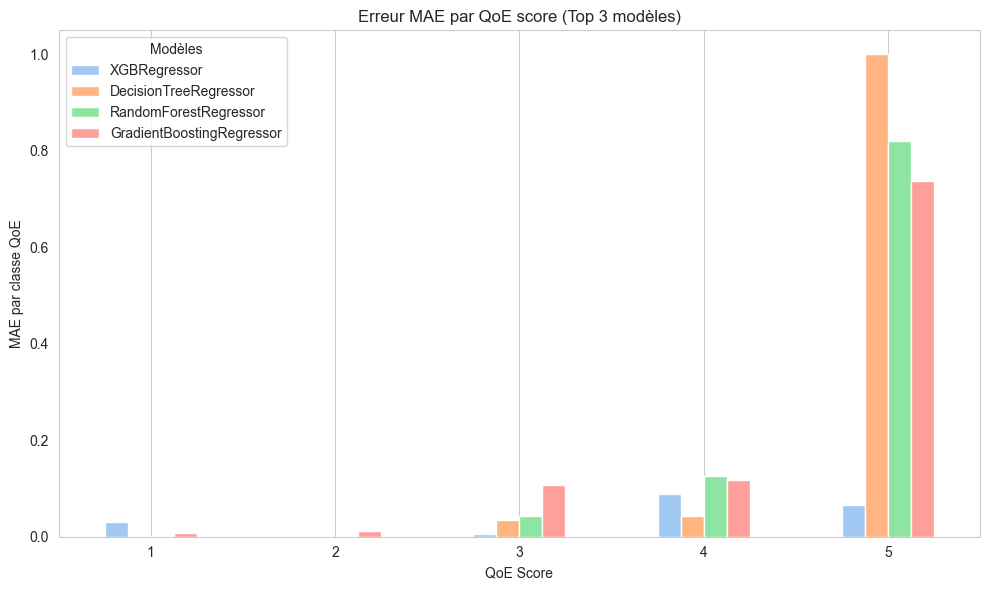

In [25]:
# Plot MAE par modèle
plt.figure(figsize=(10, 6))
df_results['MAE'].plot(kind='bar', color='skyblue')
plt.title('MAE par Modèle de Régression')
plt.ylabel('Mean Absolute Error')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Plot erreurs par QoE pour les 3 meilleurs modèles
top3 = df_results['MAE'].nsmallest(4).index
df_errors.loc[top3].T.plot(kind='bar', figsize=(10, 6))
plt.title('Erreur MAE par QoE score (Top 3 modèles)')
plt.ylabel('MAE par classe QoE')
plt.xlabel('QoE Score')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.legend(title='Modèles')
plt.tight_layout()
plt.show()


In [26]:
from sklearn.tree import plot_tree

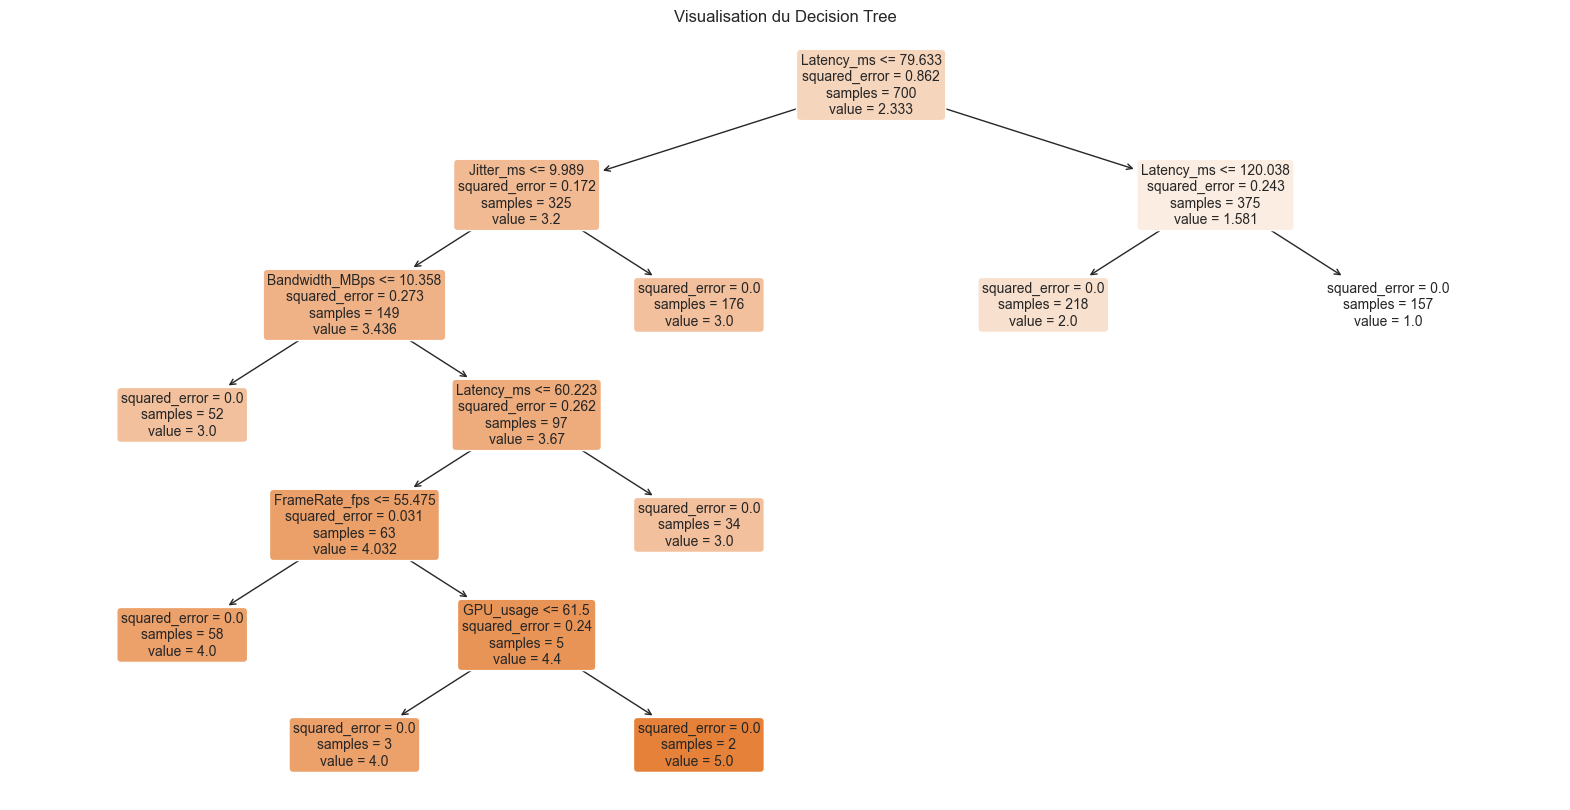

In [27]:
# On récupère l'arbre déjà entraîné
dt_model = models['DecisionTreeRegressor']
# Visualisation
plt.figure(figsize=(20, 10))
plot_tree(
    dt_model,
    feature_names=X.columns,
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Visualisation du Decision Tree")
plt.show()


# Top 4 des modèles : 
1. XGB : R2 de 0.98 et MAE à 0.01
2. DT : 0.020000	0.141421	0.975903
3. RF : 0.029700	0.134270	0.978279
4. GB : 0.058205	0.144116	0.974976

# IA Explicable 

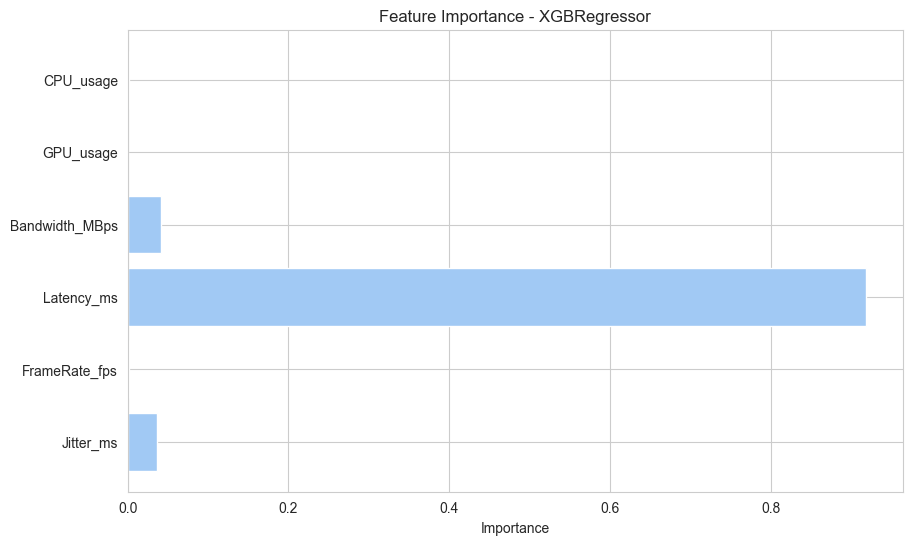

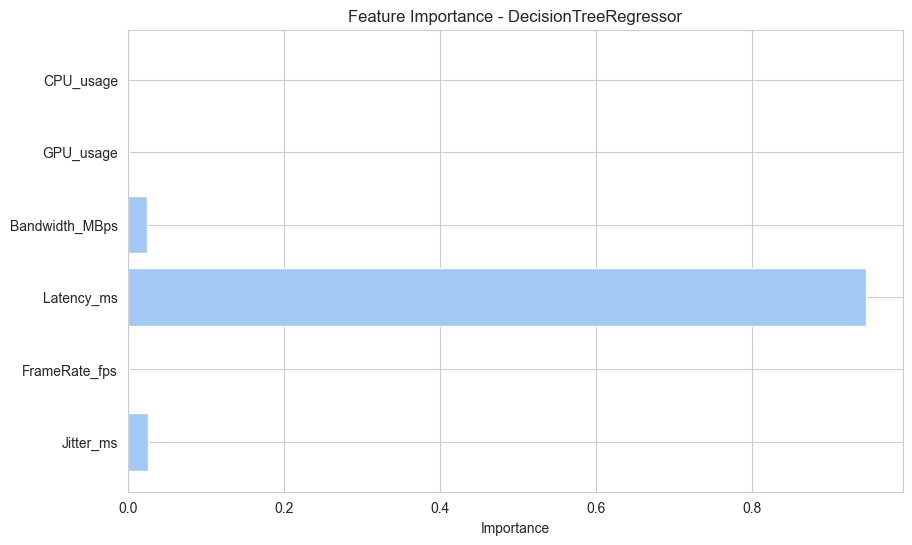

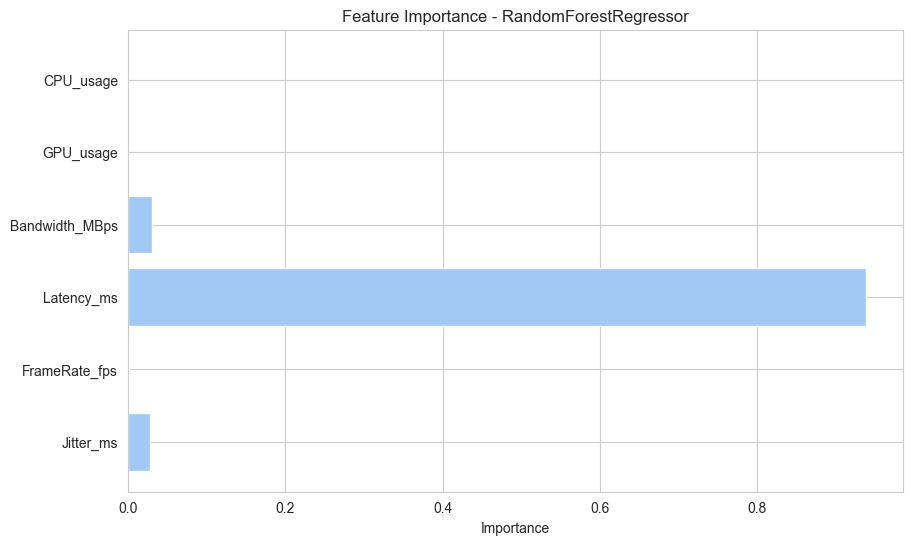

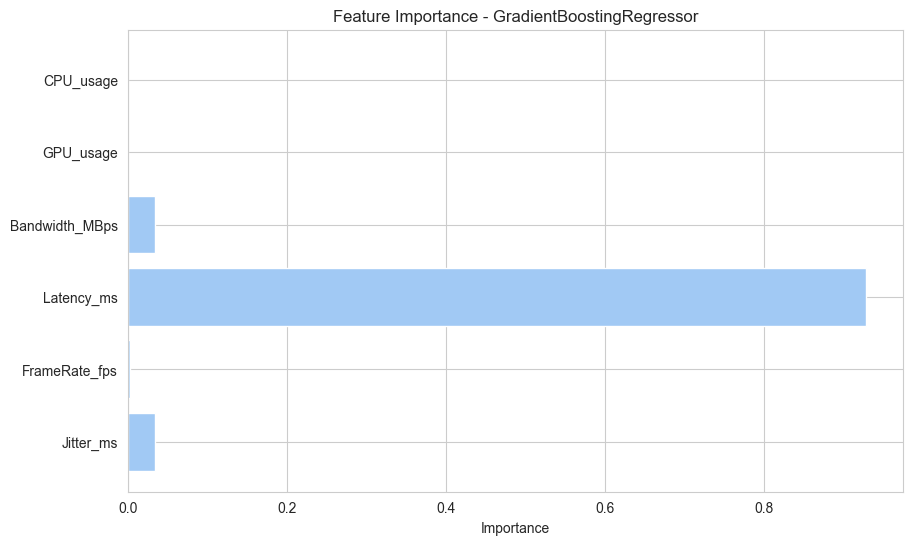

In [28]:


def plot_feature_importance(model, X, model_name):
    model.fit(X_train, y_train)
    importances = model.feature_importances_
    features = X.columns
    
    plt.figure(figsize=(10, 6))
    plt.barh(features, importances)
    plt.xlabel("Importance")
    plt.title(f"Feature Importance - {model_name}")
    plt.gca().invert_yaxis()
    plt.show()

models_to_explain = {
    "XGBRegressor": models['XGBRegressor'],
    "DecisionTreeRegressor": models['DecisionTreeRegressor'],
    "RandomForestRegressor": models['RandomForestRegressor'],
    "GradientBoostingRegressor": models['GradientBoostingRegressor']
}

for name, model in models_to_explain.items():
    plot_feature_importance(model, X_train, name)


In [29]:
import shap

/Users/zahimchared/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



SHAP pour XGBRegressor


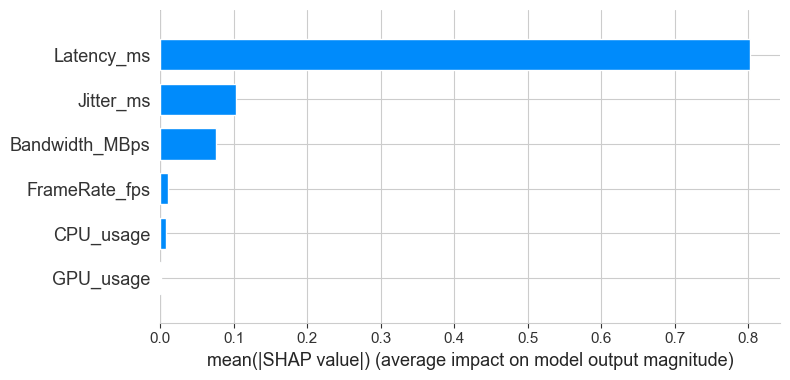

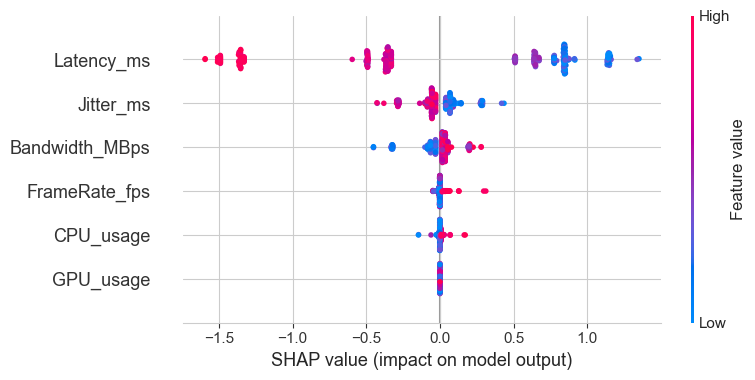

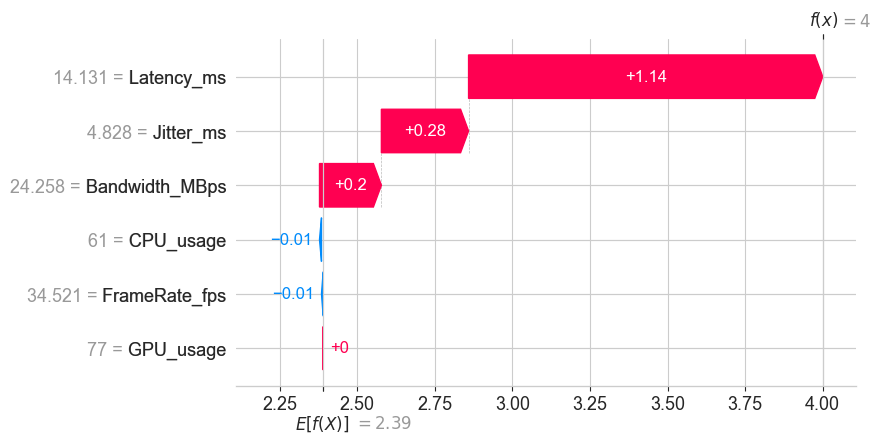


SHAP pour DecisionTreeRegressor


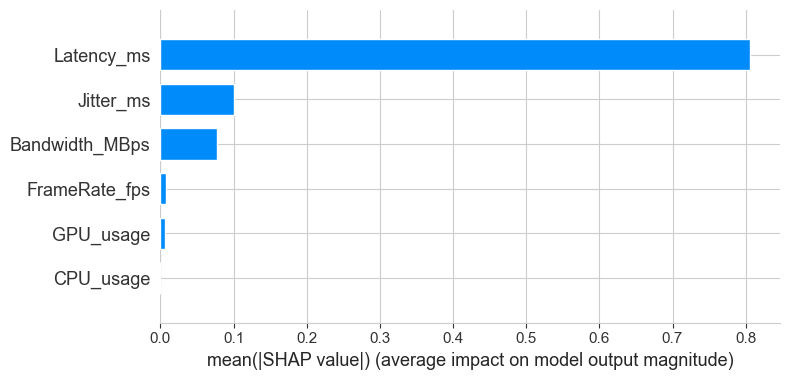

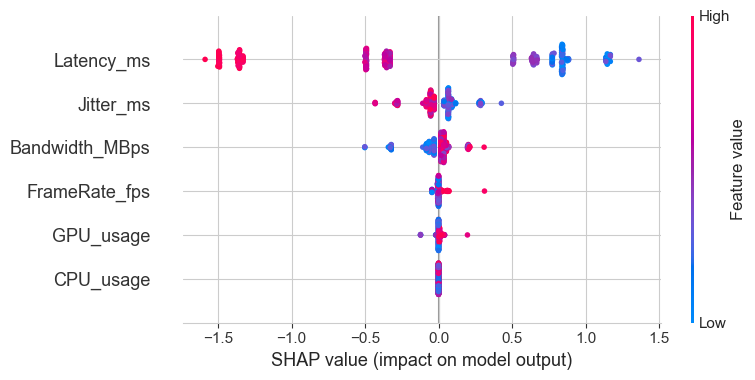

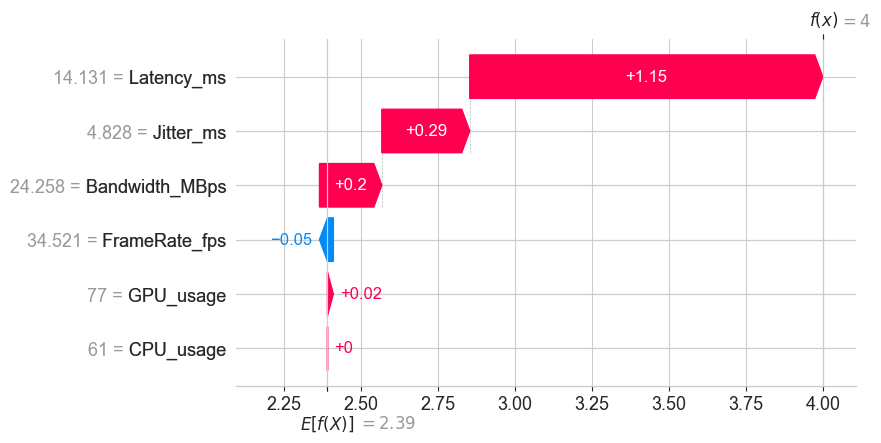


SHAP pour RandomForestRegressor


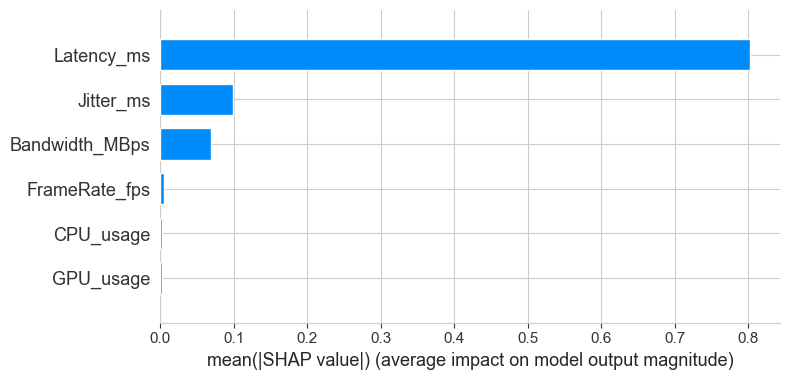

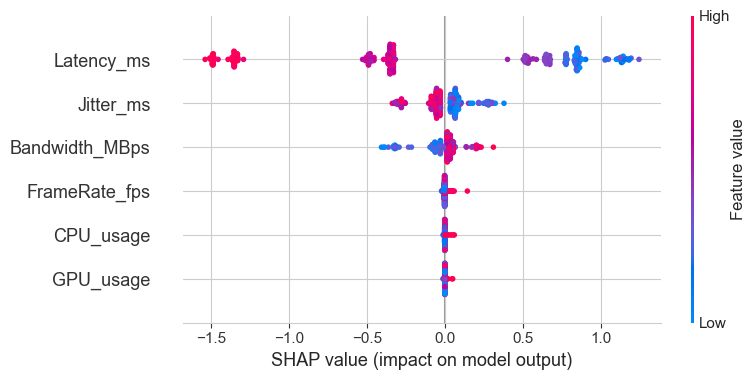

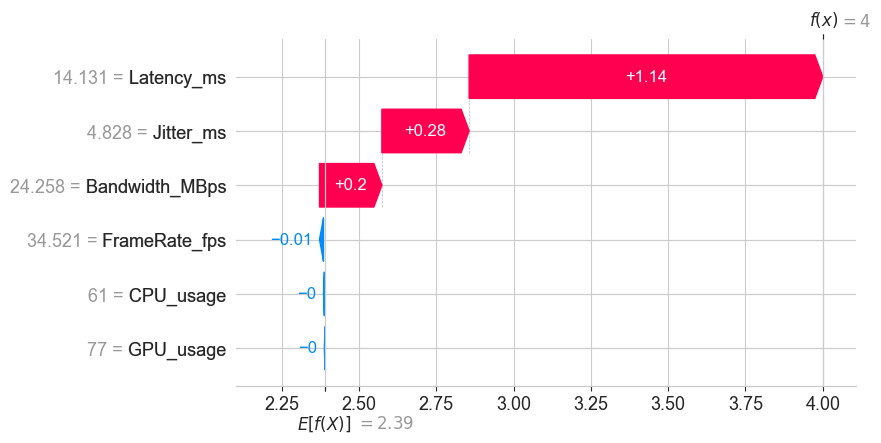


SHAP pour GradientBoostingRegressor


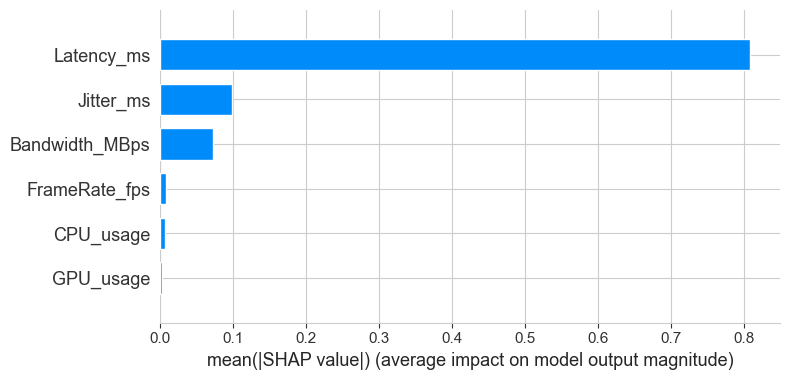

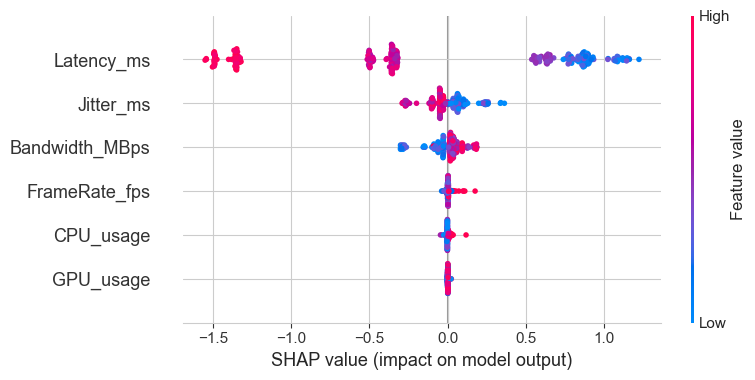

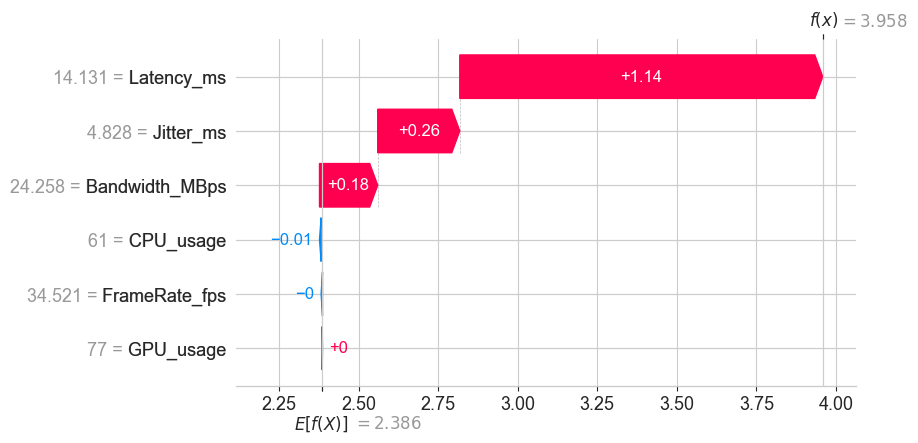

In [30]:
# SHAP est compatible directement avec les modèles basés sur les arbres
for name, model in models_to_explain.items():
    print(f"\nSHAP pour {name}")
    model.fit(X_train, y_train)
    explainer = shap.Explainer(model, X_train)
    shap_values = explainer(X_test)

    # Résumé global - barres
    shap.summary_plot(shap_values, X_test, plot_type="bar", show=True)

    # Résumé global - dispersion
    shap.summary_plot(shap_values, X_test, show=True)

    # Exemple de prédiction locale
    shap.plots.waterfall(shap_values[0])

In [31]:
from lime import lime_tabular

# Création de l'explainer LIME
lime_explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    mode='regression'
)

# Exemple avec un échantillon du test
i = 0  # index du sample à expliquer
sample = X_test.iloc[i]
sample_np = sample.values.reshape(1, -1)

for name, model in models_to_explain.items():
    print(f"\nLIME pour {name}")
    model.fit(X_train, y_train)
    
    explanation = lime_explainer.explain_instance(
        data_row=sample.values,
        predict_fn=model.predict,
        num_features=10
    )
    explanation.show_in_notebook(show_table=True)



LIME pour XGBRegressor



LIME pour DecisionTreeRegressor


/Users/zahimchared/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(



LIME pour RandomForestRegressor


/Users/zahimchared/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(



LIME pour GradientBoostingRegressor


/Users/zahimchared/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


# Oversampling method for class balance 

In [32]:
import smogn

r_index: 100%|##########| 43/43 [00:00<00:00, 2745.88it/s]


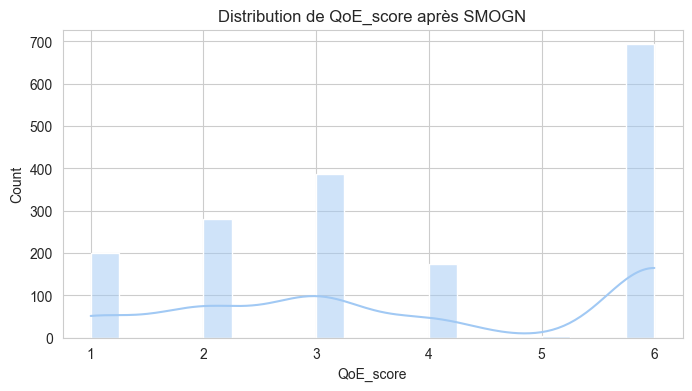

📊 Résultats comparés :


Model   Dataset       MAE      RMSE        R2
0               XGBRegressor  Original  0.016171  0.114443  0.984220
1               XGBRegressor     SMOGN  0.353181  0.664246  0.871355
2      DecisionTreeRegressor  Original  0.020000  0.141421  0.975903
3      DecisionTreeRegressor     SMOGN  0.276392  0.746071  0.837708
4      RandomForestRegressor  Original  0.029700  0.134270  0.978279
5      RandomForestRegressor     SMOGN  0.283301  0.576139  0.903219
6  GradientBoostingRegressor  Original  0.058205  0.144116  0.974976
7  GradientBoostingRegressor     SMOGN  0.409197  0.666364  0.870533

/var/folders/v_/s9924rt92rq7bt_0_y31thsw0000gn/T/ipykernel_30036/1732505465.py:81: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
/var/folders/v_/s9924rt92rq7bt_0_y31thsw0000gn/T/ipykernel_30036/1732505465.py:81: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
/var/folders/v_/s9924rt92rq7bt_0_y31thsw0000gn/T/ipykernel_30036/1732505465.py:81: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)


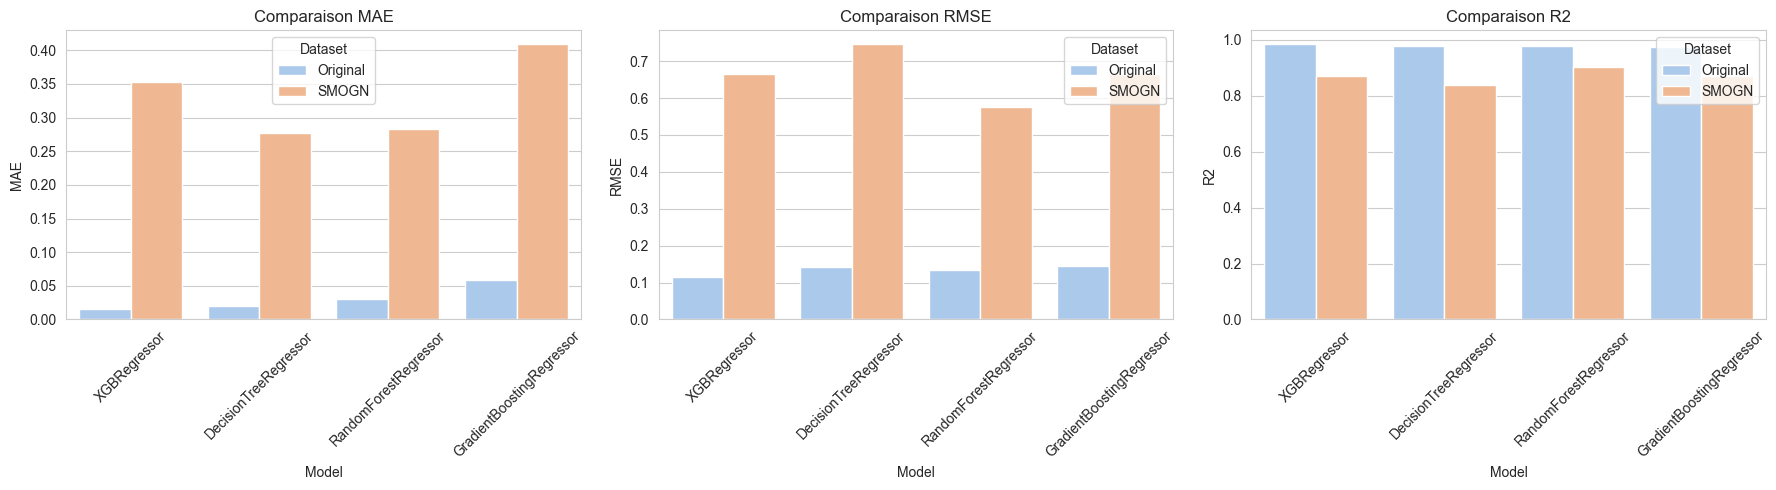

In [33]:
# Appliquer SMOGN pour équilibrer les valeurs rares de QoE_score


# Recombine les features et la cible
df = pd.concat([X, y], axis=1).rename(columns={'QoE_score': 'y'})

# Applique SMOGN
df_smogn = smogn.smoter(
    data=df,
    y='y',
    samp_method='extreme',  # se concentre sur les valeurs les plus rares (notamment 5)
    rel_thres=0.8,
    k=5,
    rel_method='auto'
)

# Distribution après SMOGN
plt.figure(figsize=(8,4))
sns.histplot(df_smogn['y'], bins=20, kde=True)
plt.title("Distribution de QoE_score après SMOGN")
plt.xlabel("QoE_score")
plt.show()

# Re-séparer X et y
X_smogn = df_smogn.drop('y', axis=1)
y_smogn = df_smogn['y']

# Split train/test (sur données SMOGN)
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_smogn, y_smogn, test_size=0.3, random_state=42
)

# 2. Réentraîner les 4 meilleurs modèles

models = {
    'XGBRegressor': XGBRegressor(random_state=42, verbosity=0),
    'DecisionTreeRegressor': DecisionTreeRegressor(random_state=42),
    'RandomForestRegressor': RandomForestRegressor(random_state=42),
    'GradientBoostingRegressor': GradientBoostingRegressor(random_state=42)
}

# 3. Fonction d’évaluation
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return {
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R2': r2_score(y_test, y_pred)
    }

# 4. Évaluer avec et sans SMOGN
results = []
for name, model in models.items():
    metrics_orig = evaluate_model(name, model, X_train, y_train, X_test, y_test)
    metrics_smogn = evaluate_model(name + " (SMOGN)", model, X_train_s, y_train_s, X_test_s, y_test_s)
    
    results.append({
        'Model': name,
        'Dataset': 'Original',
        **metrics_orig
    })
    results.append({
        'Model': name,
        'Dataset': 'SMOGN',
        **metrics_smogn
    })

results_df = pd.DataFrame(results)

# 5. Affichage tableau
print("📊 Résultats comparés :")
display(results_df)

# 6. Visualisation graphique
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
metrics = ['MAE', 'RMSE', 'R2']
for i, metric in enumerate(metrics):
    sns.barplot(data=results_df, x='Model', y=metric, hue='Dataset', ax=axes[i])
    axes[i].set_title(f'Comparaison {metric}')
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()
